In [1]:
import pandas as pd
import re
import numpy as np
import gensim
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# spacy for lemmatization
# import spacy
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
lemmatizer = WordNetLemmatizer()

import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [3]:
# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

### Loading data

In [4]:
import os
pwd = os.getcwd()

In [5]:
emails = pd.read_csv(os.path.basename(pwd +'/emails.csv'))

In [6]:
emails.count()

file       517401
message    517401
dtype: int64

In [160]:
# email_subset = emails.sample(frac=0.05, random_state=1)
email_subset = emails[500:1000]
print(email_subset.shape)
print(email_subset.head())

(500, 2)
                        file  \
500  allen-p/_sent_mail/553.   
501  allen-p/_sent_mail/554.   
502  allen-p/_sent_mail/555.   
503  allen-p/_sent_mail/556.   
504  allen-p/_sent_mail/557.   

                                               message  
500  Message-ID: <15982773.1075855728341.JavaMail.e...  
501  Message-ID: <19237776.1075855728362.JavaMail.e...  
502  Message-ID: <32350375.1075855728384.JavaMail.e...  
503  Message-ID: <30301161.1075855728406.JavaMail.e...  
504  Message-ID: <16004214.1075855728430.JavaMail.e...  


### Data Cleaning
- We have to do topic modelling on text data, I have removed redundant imformation and kept only: email body , From and To.
- I am only using 5000 emails

In [161]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to', 'date']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [162]:
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'),
        'to': map_to_list(emails, 'to'),
        'from_': map_to_list(emails, 'from'),
        'date': map_to_list(emails, 'date'),
        'TC': 0,
        'SN': 0,
        'KS': 0,
        'OT': 0,
        'print': np.nan
    }

In [163]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [164]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

In [167]:
email_df = pd.DataFrame(parse_into_emails(email_subset.message))

In [168]:
# To check there are no empty columns
email_df.drop(email_df.query(
    "body == '' | to == '' | from_ == '' | date == ''"
).index, inplace=True)
email_df.head()

,body,to,from_,date,TC,SN,KS,OT,print
0,---------------------- Forwarded by Phillip K ...,MBD <MDay@GMSSR.com>,Leslie Lawner@ENRON on 01/24/2001 08,"Thu, 25 Jan 2001 00",0,0,0,0,NaN
1,"Lucy,Here is a rentroll for this week. I stil...",stagecoachmama@hotmail.com,phillip.allen@enron.com,"Wed, 24 Jan 2001 23",0,0,0,0,NaN
2,"Larry,I met with a banker that is interested i...",llewter@austin.rr.com,phillip.allen@enron.com,"Wed, 24 Jan 2001 09",0,0,0,0,NaN
3,---------------------- Forwarded by Phillip K ...,"William S Bradford/HOU/ECT@ECT, Jeffrey T Hodg...",Travis McCullough on 01/22/2001 01,"Mon, 22 Jan 2001 06",0,0,0,0,NaN
4,By STEVE EVERLY - The Kansas City StarAs natur...,mike.grigsby@enron.com,phillip.allen@enron.com,01/20/01 22,0,0,0,0,NaN


In [169]:
email_df.count()

body     488
to       488
from_    488
date     488
TC       488
SN       488
KS       488
OT       488
print      0
dtype: int64

In [170]:
email_df['date'] = email_df['date'].str[4:16]
email_df['body'][1]

'Lucy,Here is a rentroll for this week.  I still have questions on #28,#29, and #32.'

### Remove punctuation/lower casing
- Preprocessing on the content to make it more amenable for analysis

In [171]:
# Remove punctuation
email_df['text_processed'] = \
email_df['text_processed'] = email_df['body'].str.replace(r'[^\w\s]','')
# Convert the textto lowercase
email_df['text_processed'] = \
email_df['text_processed'].map(lambda x: x.lower())


In [172]:
email_df['text_processed'] = email_df['text_processed'].map(lambda com : clean_text(com))

In [173]:
email_df['text_processed'][1]

'lucyhere is a rentroll for this week i still have questions on 2829 and 32'

### Exploratory Analysis
Wordcloud package to get a visual representation of most common words

In [174]:
# Import the wordcloud library
from wordcloud import WordCloud

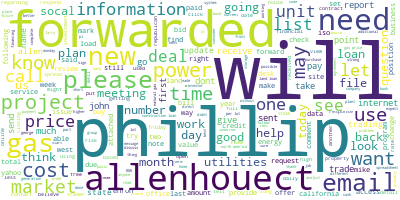

In [175]:
# Join the different processed titles together.
long_string = ','.join(list(email_df['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()


### LDA Analysis : Transform data in a format that will serve as an input for training LDA model

In [176]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Analyzing text with TF-IDF

In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
# X = vect.fit_transform(email_df.text_processed)

In [178]:
email_df.to_pickle('email.pickle')
from IPython.display import clear_output

In [ ]:
# def manually_label(email_file):
    
df = pd.read_pickle('email.pickle')
for index, row in df.iterrows():
        print('Is this sentence? Type 1 if team communication,',
              '\nType 2: social networking,','\nType 3:  knowledge sharing and ',
              '\nType 4: others . \n')
        print(row.text_processed)
        label = input()
        print(label)
        if '1' in label:
            df.loc[index, 'TC'] = 1
        if '2' in label:
            df.loc[index, 'SN'] = 1
        if '3' in label:
            df.loc[index, 'KS'] = 1
        if '4' in label:
            df.loc[index, 'OT'] = 1
        if label == '':
            df.loc[index, 'OT'] = 1
        clear_output()
        
        df.to_pickle('email.pickle')
        
print('No more labels to classify!')
    


Is this sentence? Type 1 if team communication, 
Type 2: social networking, 
Type 3:  knowledge sharing and  
Type 4: others . 

lucyhere is a schedule of the most recent utility bills and the overages thereare alot of overages it will probably get worse this month because of allthe cold weatheryou need to be very clear with all new tenants about the electricity capthis needs to be handwritten on all new leasesi am going to fax you copies of the bills that support this spreadsheet wealso need to write a short letter remind everyone about the cap and the needto conserve energy if they dont want to exceed their cap i will writesomething todaywait until you have copies of the bills and the letter before you startcollectingphillip


In [51]:
df.head(5)

,body,to,from_,date,TC,SN,KS,OT,print,text_processed
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com,14 May 2001,1,0,0,0,NaN,here is our forecast
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com,4 May 2001,0,1,0,0,NaN,traveling to have a business meeting takes the...
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com,18 Oct 2000,1,0,0,0,NaN,test successful way to go
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com,23 Oct 2000,1,0,0,0,NaN,randycan you send me a schedule of the salary ...
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com,31 Aug 2000,0,1,0,0,NaN,greghow about either next tuesday or thursdayp...


In [52]:
df.to_csv(os.path.basename(pwd +'/final_result1.csv'))

In [63]:
categories = ['TC','SN','KS','OT']

In [64]:
counts = []
for i in categories:
    counts.append((i, df[i].sum()))

In [65]:
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,TC,307
1,SN,133
2,KS,57
3,OT,43


Text(0.5, 0, 'category')

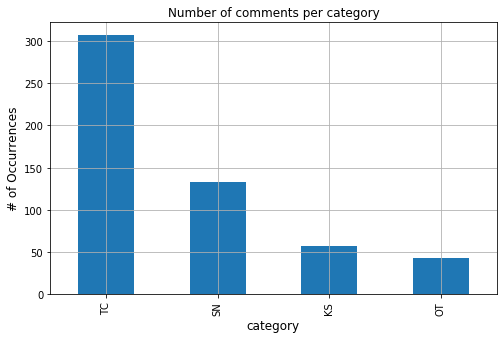

In [67]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

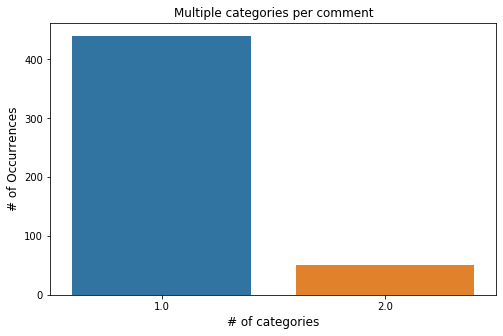

In [70]:
import seaborn as sns
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [139]:
from sklearn.model_selection import train_test_split
categories = ['TC', 'SN', 'KS', 'OT']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

X_train = train.text_processed
X_test = test.text_processed
print(X_train.shape)
print(X_test.shape)

(328,)
(162,)


### Naive Bayes

In [143]:
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [149]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing TC
Test accuracy is 0.6728395061728395
... Processing SN
Test accuracy is 0.7592592592592593
... Processing KS
Test accuracy is 0.7962962962962963
... Processing OT
Test accuracy is 0.9506172839506173


### Linear SVC

In [152]:
from sklearn.svm import LinearSVC
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])


In [153]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing TC
Test accuracy is 0.6604938271604939
... Processing SN
Test accuracy is 0.7530864197530864
... Processing KS
Test accuracy is 0.845679012345679
... Processing OT
Test accuracy is 0.9506172839506173


### Logistic Regression

In [154]:
from sklearn.linear_model import LogisticRegression
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])


In [155]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing TC
Test accuracy is 0.6975308641975309
... Processing SN
Test accuracy is 0.7530864197530864
... Processing KS
Test accuracy is 0.7962962962962963
... Processing OT
Test accuracy is 0.9567901234567902


### Artificial Neural Network

### SVM

In [158]:
from sklearn.svm import SVC
SVM_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', SVC()),
            ])

In [159]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVM_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVM_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing TC
Test accuracy is 0.6728395061728395
... Processing SN
Test accuracy is 0.7407407407407407
... Processing KS
Test accuracy is 0.808641975308642
... Processing OT
Test accuracy is 0.9567901234567902


In [75]:
stop_words = stopwords.words('english')# replace with space
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [78]:
print(email_df.iloc[1]['text_processed'])

traveling to have a business meeting takes the fun out of the trip especially if you have to prepare a presentation i would suggest holding the business plan meetings here then take a trip without any formal business meetings i would even try and get some honest opinions on whether a trip is even desired or necessaryas far as the business meetings i think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not too often the presenter speaks and the others are quiet just waiting for their turn the meetings might be better if held in a round table discussion formatmy suggestion for where to go is austin play golf and rent a ski boat and jet skis flying somewhere takes too much time


In [79]:
data = email_df.text_processed.values.tolist()

In [81]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(i) for i in sent])
    return texts_out

In [82]:
data_words = list(sent_to_words(data))

In [84]:
print(data_words[1])

['traveling', 'to', 'have', 'business', 'meeting', 'takes', 'the', 'fun', 'out', 'of', 'the', 'trip', 'especially', 'if', 'you', 'have', 'to', 'prepare', 'presentation', 'would', 'suggest', 'holding', 'the', 'business', 'plan', 'meetings', 'here', 'then', 'take', 'trip', 'without', 'any', 'formal', 'business', 'meetings', 'would', 'even', 'try', 'and', 'get', 'some', 'honest', 'opinions', 'on', 'whether', 'trip', 'is', 'even', 'desired', 'or', 'necessaryas', 'far', 'as', 'the', 'business', 'meetings', 'think', 'it', 'would', 'be', 'more', 'productive', 'to', 'try', 'and', 'stimulate', 'discussions', 'across', 'the', 'different', 'groups', 'about', 'what', 'is', 'working', 'and', 'what', 'is', 'not', 'too', 'often', 'the', 'presenter', 'speaks', 'and', 'the', 'others', 'are', 'quiet', 'just', 'waiting', 'for', 'their', 'turn', 'the', 'meetings', 'might', 'be', 'better', 'if', 'held', 'in', 'round', 'table', 'discussion', 'formatmy', 'suggestion', 'for', 'where', 'to', 'go', 'is', 'austi

In [ ]:
# ugs = word_tokenize(raw)
# bgs = nltk.bigrams(ugs)
# tgs = nltk.trigrams(ugs)
# fogs=nltk.ngrams(ugs,4)
# figs=nltk.ngrams(ugs,5)

In [ ]:
# # Build the bigram and trigram models
# bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

In [ ]:
# # Faster way to get a sentence clubbed as a trigram/bigram
# # bigram_mod = Phraser(bigram)
# # trigram_mod = Phraser(trigram)
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# print(bigram_mod[data_words[11]])

In [89]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [91]:
#  Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

In [92]:
# data_lemmatized = lemmatization(data_words_bigrams)
data_lemmatized = lemmatization(data_words_nostops)

In [94]:
print(data_lemmatized[1])

['traveling', 'business', 'meeting', 'take', 'fun', 'trip', 'especially', 'prepare', 'presentation', 'would', 'suggest', 'holding', 'business', 'plan', 'meeting', 'take', 'trip', 'without', 'formal', 'business', 'meeting', 'would', 'even', 'try', 'get', 'honest', 'opinion', 'whether', 'trip', 'even', 'desired', 'necessaryas', 'far', 'business', 'meeting', 'think', 'would', 'productive', 'try', 'stimulate', 'discussion', 'across', 'different', 'group', 'working', 'often', 'presenter', 'speaks', 'others', 'quiet', 'waiting', 'turn', 'meeting', 'might', 'better', 'held', 'round', 'table', 'discussion', 'formatmy', 'suggestion', 'go', 'austin', 'play', 'golf', 'rent', 'ski', 'boat', 'jet', 'ski', 'flying', 'somewhere', 'take', 'much', 'time']


### Bag of Words on the Data set

In [95]:
import gensim.corpora as corpora# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)# Create Corpus

In [117]:
print('Number of unique words in initital documents:', len(dictionary))

Number of unique words in initital documents: 200


In [118]:
# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words after removing rare and common words: 200


In [122]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 austin
1 better
2 different
3 even
4 get
5 go
6 group
7 meeting
8 might
9 much
10 plan


### Gensim doc2bow

In [124]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data_lemmatized]
bow_corpus[489]

[(4, 1),
 (11, 2),
 (19, 1),
 (21, 1),
 (26, 1),
 (35, 1),
 (40, 1),
 (70, 1),
 (78, 1),
 (100, 1),
 (109, 3),
 (113, 2),
 (117, 1),
 (124, 4),
 (161, 1),
 (171, 3)]

In [125]:
bow_doc_489 = bow_corpus[489]
for i in range(len(bow_doc_489)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_489[i][0], 
                                               dictionary[bow_doc_489[i][0]], 
bow_doc_489[i][1]))

Word 4 ("get") appears 1 time.
Word 11 ("rent") appears 2 time.
Word 19 ("need") appears 1 time.
Word 21 ("schedule") appears 1 time.
Word 26 ("phillip") appears 1 time.
Word 35 ("deal") appears 1 time.
Word 40 ("let") appears 1 time.
Word 70 ("due") appears 1 time.
Word 78 ("know") appears 1 time.
Word 100 ("please") appears 1 time.
Word 109 ("one") appears 3 time.
Word 113 ("two") appears 2 time.
Word 117 ("fax") appears 1 time.
Word 124 ("paid") appears 4 time.
Word 161 ("back") appears 1 time.
Word 171 ("week") appears 3 time.


### TF-IDF

In [116]:
from gensim import corpora, models
from pprint import pprint

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    if doc != []:
        pprint(doc)
        break

[(0, 0.16348819730522351),
 (1, 0.15761883073314112),
 (2, 0.15240304588412626),
 (3, 0.3209234907022144),
 (4, 0.08864510663841858),
 (5, 0.12375524061380301),
 (6, 0.1604617453511072),
 (7, 0.6121710156443381),
 (8, 0.14144797423998737),
 (9, 0.14770975924870985),
 (10, 0.11302400581243485),
 (11, 0.13953367867031669),
 (12, 0.39295182269877643),
 (13, 0.11302400581243485),
 (14, 0.1099309907108412),
 (15, 0.25591497789095163),
 (16, 0.1604617453511072),
 (17, 0.2322802029156295)]


### LDA using Bag of Words

In [126]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=10, 
                                       id2word=dictionary,
                                       passes=2, workers=2)

In [127]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.040*"phillip" + 0.039*"basis" + 0.030*"forwarded" + 0.030*"would" + 0.027*"please" + 0.026*"allenhouect" + 0.025*"need" + 0.023*"think" + 0.017*"gas" + 0.016*"email"
Topic: 1 
Words: 0.066*"power" + 0.023*"company" + 0.021*"need" + 0.020*"phillip" + 0.019*"paid" + 0.019*"file" + 0.016*"call" + 0.016*"rent" + 0.015*"would" + 0.015*"get"
Topic: 2 
Words: 0.041*"position" + 0.041*"phillip" + 0.031*"forwarded" + 0.030*"gas" + 0.029*"deal" + 0.028*"allenhouect" + 0.022*"would" + 0.022*"need" + 0.020*"price" + 0.017*"project"
Topic: 3 
Words: 0.079*"cost" + 0.072*"loan" + 0.047*"would" + 0.037*"unit" + 0.028*"construction" + 0.026*"land" + 0.023*"total" + 0.020*"project" + 0.017*"value" + 0.015*"need"
Topic: 4 
Words: 0.109*"phillip" + 0.096*"forwarded" + 0.094*"allenhouect" + 0.029*"access" + 0.029*"rent" + 0.026*"meeting" + 0.018*"allen" + 0.017*"please" + 0.017*"date" + 0.017*"address"
Topic: 5 
Words: 0.042*"would" + 0.041*"meeting" + 0.028*"may" + 0.024*"john" + 0.023

### Running LDA using TF-IDF

In [128]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10,
                                             id2word=dictionary,
                                             passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.064*"phillip" + 0.058*"forwarded" + 0.057*"allenhouect" + 0.020*"north" + 0.019*"u" + 0.019*"hunter" + 0.018*"one" + 0.018*"john" + 0.018*"america" + 0.017*"enron"
Topic: 1 Word: 0.066*"tim" + 0.041*"phillip" + 0.039*"forwarded" + 0.038*"allenhouect" + 0.029*"loan" + 0.023*"jeff" + 0.019*"scott" + 0.016*"john" + 0.014*"america" + 0.014*"north"
Topic: 2 Word: 0.036*"please" + 0.029*"email" + 0.028*"need" + 0.024*"desk" + 0.023*"know" + 0.022*"call" + 0.022*"get" + 0.022*"let" + 0.021*"would" + 0.021*"socal"
Topic: 3 Word: 0.024*"send" + 0.023*"sent" + 0.018*"would" + 0.018*"access" + 0.018*"address" + 0.016*"track" + 0.015*"may" + 0.014*"fax" + 0.014*"good" + 0.013*"think"
Topic: 4 Word: 0.040*"received" + 0.033*"bring" + 0.033*"spreadsheet" + 0.033*"file" + 0.024*"number" + 0.023*"phillip" + 0.022*"please" + 0.022*"socal" + 0.022*"forwarded" + 0.022*"allenhouect"
Topic: 5 Word: 0.030*"id" + 0.029*"date" + 0.029*"meeting" + 0.028*"request" + 0.025*"phillip" + 0.023*"way

In [132]:
for index, score in sorted(lda_model[bow_corpus[489]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6233623027801514	 
Topic: 0.038*"need" + 0.026*"get" + 0.026*"would" + 0.025*"time" + 0.022*"know" + 0.021*"work" + 0.021*"let" + 0.016*"going" + 0.016*"unit" + 0.014*"want"

Score: 0.3458632528781891	 
Topic: 0.066*"power" + 0.023*"company" + 0.021*"need" + 0.020*"phillip" + 0.019*"paid" + 0.019*"file" + 0.016*"call" + 0.016*"rent" + 0.015*"would" + 0.015*"get"


In [133]:
for index, score in sorted(lda_model_tfidf[bow_corpus[489]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.5195339322090149	 
Topic: 0.029*"going" + 0.028*"work" + 0.019*"week" + 0.017*"need" + 0.016*"get" + 0.015*"california" + 0.015*"new" + 0.014*"site" + 0.014*"take" + 0.014*"try"

Score: 0.26903125643730164	 
Topic: 0.030*"rent" + 0.027*"email" + 0.025*"basis" + 0.022*"might" + 0.021*"dont" + 0.021*"look" + 0.021*"think" + 0.020*"list" + 0.019*"call" + 0.019*"deposit"

Score: 0.184502512216568	 
Topic: 0.024*"send" + 0.023*"sent" + 0.018*"would" + 0.018*"access" + 0.018*"address" + 0.016*"track" + 0.015*"may" + 0.014*"fax" + 0.014*"good" + 0.013*"think"
